<a href="https://colab.research.google.com/github/ziangzhou-duke/econ211/blob/master/Job_Searching_Model_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research question: When to Accept or Reject an Offer? 

References: J J McCall. Economics of Information and Job Search. The Quarterly Journal of Economics, 84(1):113–126, 1970.

### install the QuantEcon Library 

In [3]:
!pip install quantecon ###if you use anaconda, type in the command instead: !conda install -y quantecon

     |████████████████████████████████| 235kB 5.6MB/s 


In [1]:
!pip install numba 

In [4]:
import numpy as np
from numba import jit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
import quantecon as qe
from quantecon.distributions import BetaBinomial

/usr/local/lib/python3.6/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


# The Model

### The Objective function

The agent is infinitely lived and aims to maximize the expected discounted sum of earnings $E\sum_{t=0}^{\infty}\beta^{t}y_t$


*   $\beta$ is the discount factor
*   $y_{t}$ is income, equal to the wage $w_{t}$ when employed, and compensation $c$ when unemployed



### The State Value Function

$s_t$ is an i.i.d. random variable called "the State", it is distributed over a set $S$ with probability $p(s)$ for $s\in S$

*   $w_t =w(s_t)$
*   **State value function**: $v^{*}(s)$ denotes the value of the objective function given state s when an agent in this situation makes an optimal decision

*   **The bellman equation**: the state value function must satisfy the following condition
$v^{*}=max[w(s)/(1-\beta),c+\beta\sum_{s'\in S}v*(s')q(s') ]$







### The optimal policy
Choose the strategy that (accept or reject an offer) gives a higher value

$\sigma(s) =1[w(s)/(1-\beta)>c+\beta\sum_{s'\in S}v*(s')q(s') ]$

here $1[P]$ =1 if statement P is true and 0 otherwise

we can also write this as $\sigma(s) =1[w(s)>\overline{w}]$, where $\overline{w}$ is the reservation wage which is a constant depending on β,c,and the wage distribution. From the above optimal strategy, we can see that actually $\overline{w}=(1-\beta)(c+\beta\sum_{s'\in S}v*(s')q(s') )$.


The agent should accept if and only if the current wage offer exceeds the reservation wage.


# Simulation

## Simulate wage distributions

###BetaBinominal distribution: https://en.wikipedia.org/wiki/Beta-binomial_distribution

BetaBinominal(n,a,b) is a distribution on finite support {0, 1, 2, ..,n} with parameter a and b. 

Special case: 


*  It reduces to the Bernoulli distribution as a special case when n = 1.
*  For a = b = 1, it is the discrete uniform distribution from 0 to n.


Change following two boxes only to simulate the model for your own parameter of choices. 


In [5]:
n, a, b = 50, 1, 1                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

In [6]:
w_min, w_max = 50, 100
w_default = np.linspace(w_min, w_max, n+1)

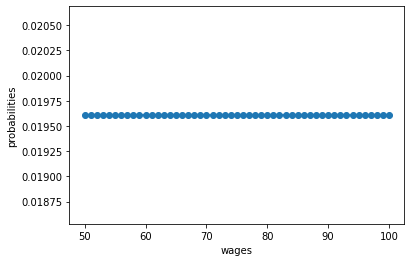

In [7]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

## Solve for the optimal policy and compute reservation wage

references:  compiling python code with @jit https://numba.pydata.org/numba-doc/latest/user/jit.html

In [8]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

In [9]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  """Entry point for launching an IPython kernel.


In [10]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

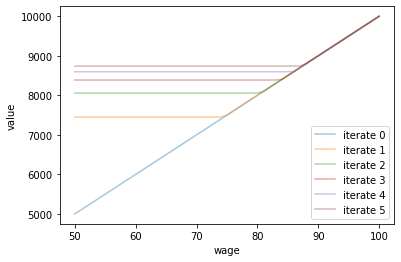

In [11]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

In [12]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    i = 0
    error = tol + 1
    while i < max_iter and error > tol:

        for i in range(n):
            v_next[i] = np.max(mcm.state_action_values(i, v))

        error = np.max(np.abs(v_next - v))
        i += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))

In [13]:
compute_reservation_wage(mcm) 

92.17437718608396

### change the parameter in the following box to calculate new reservation wage for parameters of your choice. 

In [14]:
mcm = McCallModel(c=20, β=0.999)
compute_reservation_wage(mcm)

97.67814959177011

## Comparative Statics 

### the resevation wage

In [17]:
grid_size = 25
R = np.empty((grid_size, grid_size))

c_vals = np.linspace(10.0, 30.0, grid_size) ### change parameter of the unemployment conpensation
β_vals = np.linspace(0.9, 0.99, grid_size) ### change parameter of the discount factors

for i, c in enumerate(c_vals):
    for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[i, j] = compute_reservation_wage(mcm)

contour plot : 

https://problemsolvingwithpython.com/06-Plotting-with-Matplotlib/06.14-Contour-Plots/

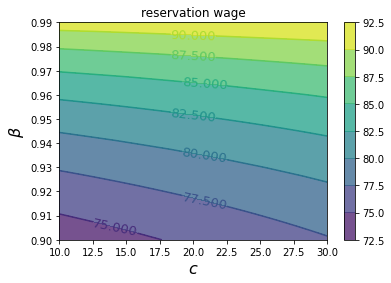

In [18]:
fig, ax = plt.subplots()

cs1 = ax.contourf(c_vals, β_vals, R.T, alpha=0.75)
ctr1 = ax.contour(c_vals, β_vals, R.T)

plt.clabel(ctr1, inline=1, fontsize=13)
plt.colorbar(cs1, ax=ax)


ax.set_title("reservation wage")
ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$β$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### in the following box, we keep unemployment compensation c fixed, and we discuss how the reservation wage change when the discount factor $\beta$ changes

In [20]:
line_lens =100 ### change to value of your choice
c=50 # please change c to value of your choice
β_vals = np.linspace(0, 0.9999, line_lens) # please change the range of beta to value of your choice
R = np.empty((line_lens,1))
for j, β in enumerate(β_vals):
        mcm = McCallModel(c=c, β=β)
        R[j] = compute_reservation_wage(mcm)

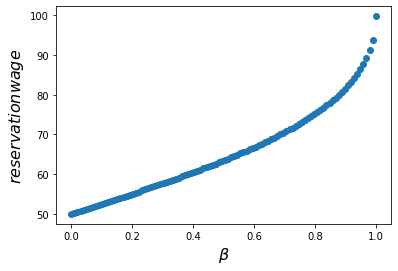

In [21]:
fig, ax = plt.subplots()

cs2 = ax.scatter(β_vals, R)


ax.set_xlabel("$β$", fontsize=16)
ax.set_ylabel("$reservation wage$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### in the following box, we keep the discount factor $\beta$ constant, we discuss how the reservation wage change when the unemployment compensation changes

In [22]:
line_lens =25 ## change line_lens to value of your choice
β=0.5 ### change beta to value of your choice
c_vals = np.linspace(10, 80, line_lens) ### change c to the range of your choice
R = np.empty((line_lens,1))
for i, c in enumerate(c_vals):
        mcm = McCallModel(c=c, β=β)
        R[i] = compute_reservation_wage(mcm)

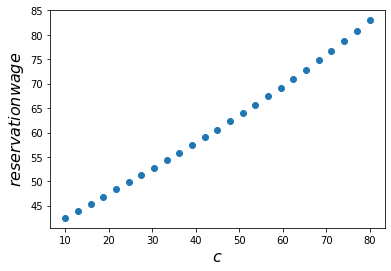

In [23]:
fig, ax = plt.subplots()

cs3 = ax.scatter(c_vals, R)


ax.set_xlabel("$c$", fontsize=16)
ax.set_ylabel("$reservation wage$", fontsize=16)

ax.ticklabel_format(useOffset=False)

plt.show()

### the duration of unemploymnet 

comparative statics for the unemployment compensation

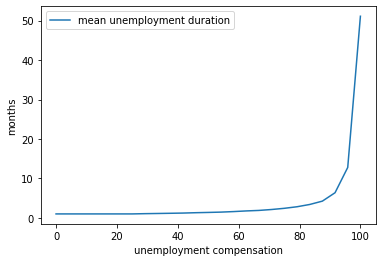

In [25]:
cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

β =0.5 ### change the discount factor beta to value of your choice
c_vals = np.linspace(0, 100, 25) ### change the unemployment compensation to value of your choice


stop_times = np.empty_like(c_vals)
for i, c in enumerate(c_vals):
    mcm = McCallModel(c=c, β=β)
    w_bar = compute_reservation_wage(mcm)
    stop_times[i] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(c_vals, stop_times, label="mean unemployment duration")
ax.set(xlabel="unemployment compensation", ylabel="months")
ax.legend()

plt.show()

comparative statics for the discount factor

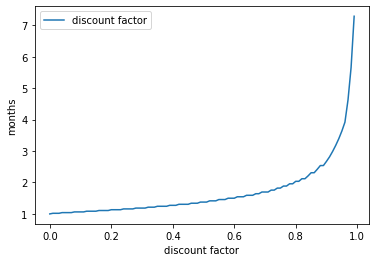

In [26]:
cdf = np.cumsum(q_default)

@jit(nopython=True)
def compute_stopping_time(w_bar, seed=1234):

    np.random.seed(seed)
    t = 1
    while True:
        # Generate a wage draw
        w = w_default[qe.random.draw(cdf)]
        # Stop when the draw is above the reservation wage
        if w >= w_bar:
            stopping_time = t
            break
        else:
            t += 1
    return stopping_time

@jit(nopython=True)
def compute_mean_stopping_time(w_bar, num_reps=100000):
    obs = np.empty(num_reps)
    for i in range(num_reps):
        obs[i] = compute_stopping_time(w_bar, seed=i)
    return obs.mean()

c=50 ### change the unemployment compensation c to values of your choice
β_vals = np.linspace(0, 0.99, 100) ### change discount factor beta to range of your choice.
stop_times = np.empty_like(β_vals)
for j, β in enumerate(β_vals):
    mcm = McCallModel(c=c, β=β)
    w_bar = compute_reservation_wage(mcm)
    stop_times[j] = compute_mean_stopping_time(w_bar)

fig, ax = plt.subplots()

ax.plot(β_vals, stop_times, label="discount factor")
ax.set(xlabel="discount factor", ylabel="months")
ax.legend()

plt.show()